In [44]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

from mrs_denoising import denoising, utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Assess the performance of MP thresholding for SVHT in low SNR data.
If MP thresholding predicts a threshold larger that the smallest singular value of the noiseless data + noise then the denoised data will be necessarily biased.

Does deliberately lowering the SV threshold, either by a deliberate offset or by using a soft thresholding function decrease the bias?

### Utility functions

In [2]:
def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

# Construct some rank = 3 data.
Numerical phantom with three different overlaping regions of different peak concentration

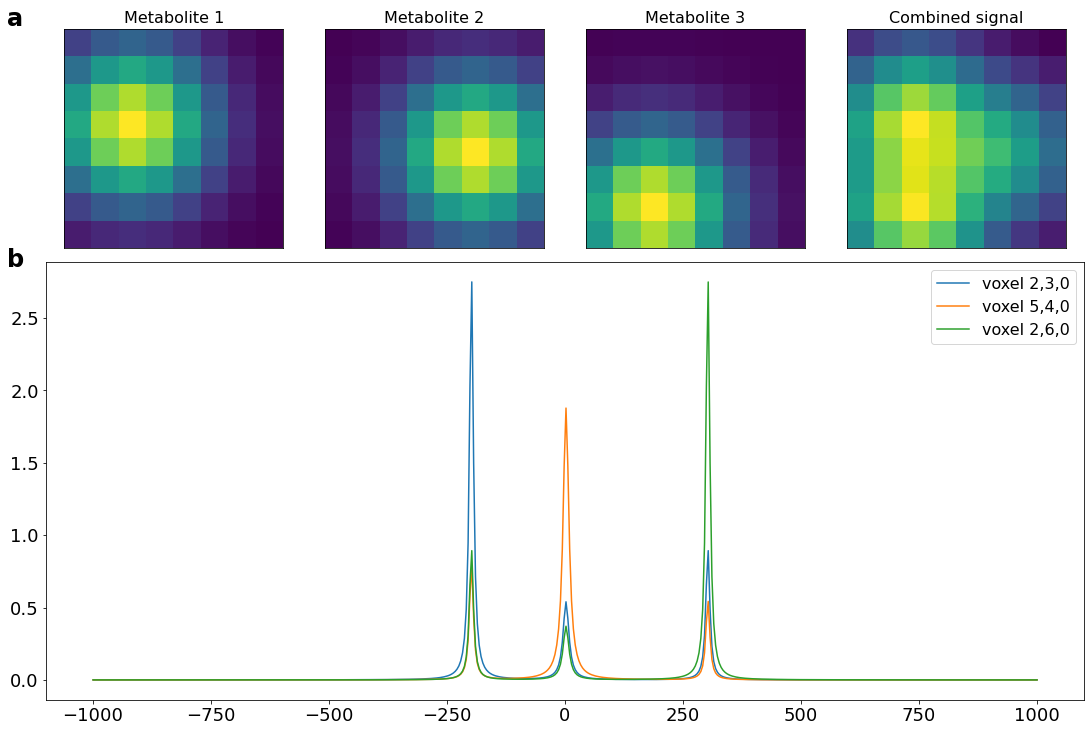

In [50]:
peak_frequencies = [-200, 0, 300]
peak_amps = [1, 1, 1]
peak_lw = [10, 15, 10]
centre_X = [2, 5, 2]
centre_Y = [3, 4, 6]

Nt = 512
bandwidth = 2000
dt = 1 / bandwidth
time_axis = dt * np.arange(0, Nt)

xx, yy, zz = np.arange(0,8), np.arange(0,8), np.arange(0,1)
X, Y, Z = np.meshgrid(xx, yy, zz)

def peak(x, c, omega, alpha, phi=0.0):
    return c * np.exp((alpha + 1j * 2 * np.pi * omega) * x) * np.exp(1j * phi)

sigma=2
noiseless = np.zeros(X.shape + (Nt,),dtype=complex)
weights = []
for pdx in range(3):
    gauss_weight = np.exp( -((X-centre_X[pdx])**2 + (Y-centre_Y[pdx])**2) / (2.*sigma**2) )
    weights.append(gauss_weight)

    fid = peak(time_axis, peak_amps[pdx], peak_frequencies[pdx], -np.pi * peak_lw[pdx])

    noiseless += gauss_weight[:,:,:,np.newaxis] * fid

# Plotting
plt.rcParams.update({'font.size': 18})
weights = np.moveaxis(np.asarray(weights),0,-1)

def no_ticks(ax):
    ax.set_xticks([])
    ax.set_yticks([])

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
ax1.matshow(weights[:,:,0,0])
ax2.matshow(weights[:,:,0,1])
ax3.matshow(weights[:,:,0,2])
ax4.matshow(np.mean(np.abs(noiseless),axis=3))
ax1.set_title('Metabolite 1')
ax2.set_title('Metabolite 2')
ax3.set_title('Metabolite 3')
ax4.set_title('Combined signal')
no_ticks(ax1)
no_ticks(ax2)
no_ticks(ax3)
no_ticks(ax4)

ax_big = fig.add_subplot(gs[1:, :])

freq_axis = np.linspace(-bandwidth/2, bandwidth/2, Nt)
ax_big.plot(freq_axis, FID2Spec(noiseless[3, 2, 0, :]).real, label='voxel 2,3,0')
ax_big.plot(freq_axis, FID2Spec(noiseless[4, 5, 0, :]).real, label='voxel 5,4,0')
ax_big.plot(freq_axis, FID2Spec(noiseless[6, 2, 0, :]).real, label='voxel 2,6,0')
ax_big.legend()

fig.text(0.00, 0.975,'a',fontweight='bold',fontsize=24)
fig.text(0.00, 0.64,'b',fontweight='bold',fontsize=24)

plt.savefig('figures/supp_fig_1_bias_1.png', bbox_inches='tight', dpi=300)

## Look at rank properties of the data (with added noise)

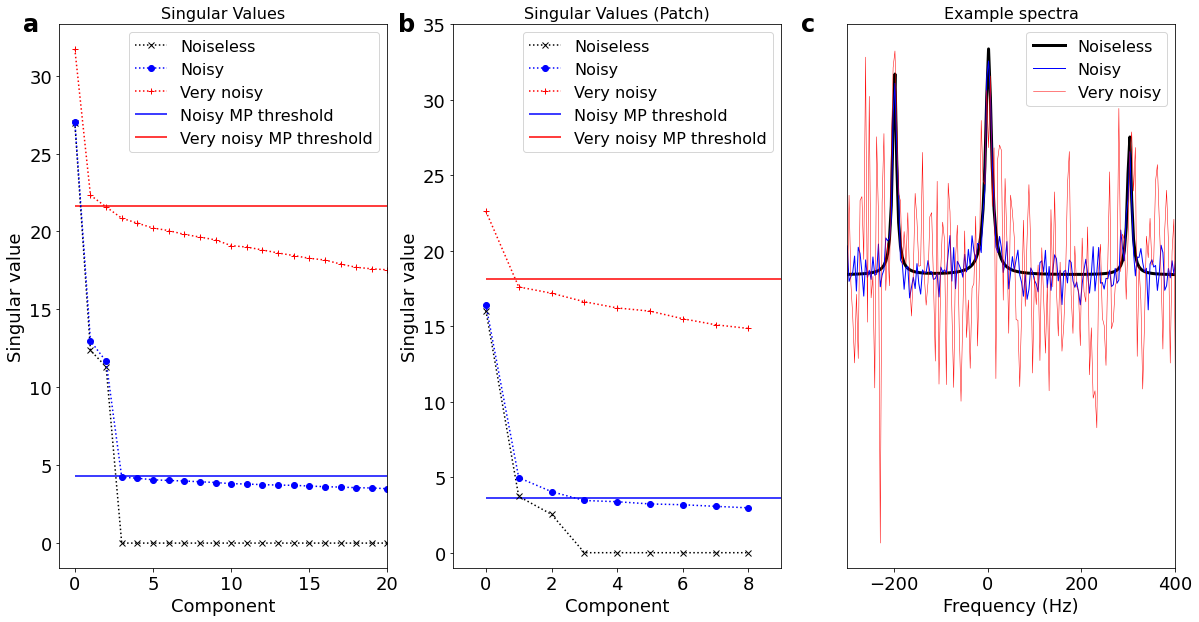

In [58]:
_, S, _ = utils.lsvd(noiseless.reshape(-1, 512))
_, S_patch, _ = utils.lsvd(noiseless[2:5, 2:5, 0, :].reshape(-1, 512))

rng = np.random.default_rng()
sd_noisy = 0.1
noisy = noiseless + sd_noisy * rng.standard_normal(size=noiseless.shape) + sd_noisy * 1j * rng.standard_normal(size=noiseless.shape)
_, S_noisy, _ = utils.lsvd(noisy.reshape(-1, 512))
mp_thres_noisy = denoising.max_sv_from_mp(2*sd_noisy**2, noisy.reshape(-1, 512).shape)

_, S_noisy_patch, _ = utils.lsvd(noisy[2:5, 2:5, 0, :].reshape(-1, 512))
mp_thres_noisy_patch = denoising.max_sv_from_mp(2*sd_noisy**2, noisy[2:5, 2:5, 0, :].reshape(-1, 512).shape)

sd_v_noisy = 0.5
vnoisy = noiseless + sd_v_noisy * rng.standard_normal(size=noiseless.shape) + sd_v_noisy * 1j * rng.standard_normal(size=noiseless.shape)
_, S_vnoisy, _ = utils.lsvd(vnoisy.reshape(-1, 512))
mp_thres_vnoisy = denoising.max_sv_from_mp(2*sd_v_noisy**2, vnoisy.reshape(-1, 512).shape)

_, S_vnoisy_patch, _ = utils.lsvd(vnoisy[2:5, 2:5, 0, :].reshape(-1, 512))
mp_thres_vnoisy_patch = denoising.max_sv_from_mp(2*sd_v_noisy**2, vnoisy[2:5, 2:5, 0, :].reshape(-1, 512).shape)

# Plot
plt.rc('legend', fontsize=16)    # legend fontsize
fig, axes = plt.subplots(1, 3, figsize=(20,10))
axes[0].plot(np.diag(S)[::-1].real,'kx:', label='Noiseless')
axes[0].plot(np.diag(S_noisy)[::-1].real,'bo:', label='Noisy')
axes[0].plot(np.diag(S_vnoisy)[::-1].real,'r+:', label='Very noisy')
axes[0].hlines(mp_thres_noisy, 0, 64,color='b', label='Noisy MP threshold')
axes[0].hlines(mp_thres_vnoisy, 0, 64,color='r', label='Very noisy MP threshold')
axes[0].set_xlim([-1, 20])
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Singular value')
axes[0].set_title('Singular Values')
axes[0].legend()

axes[1].plot(np.diag(S_patch)[::-1].real,'kx:',label='Noiseless')
axes[1].plot(np.diag(S_noisy_patch)[::-1].real,'bo:',label='Noisy')
axes[1].plot(np.diag(S_vnoisy_patch)[::-1].real,'r+:',label='Very noisy')
axes[1].hlines(mp_thres_noisy_patch, 0, 64,color='b', label='Noisy MP threshold')
axes[1].hlines(mp_thres_vnoisy_patch, 0, 64,color='r', label='Very noisy MP threshold')
axes[1].set_xlim([-1, 9])
axes[1].set_ylim([-1, 35])
axes[1].set_title('Singular Values (Patch)')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Singular value')
axes[1].legend()

freq_axis = np.linspace(-bandwidth/2, bandwidth/2, Nt)
axes[2].plot(freq_axis, FID2Spec(noiseless[4,4,0,:]).real,'k', linewidth=3, label='Noiseless')
axes[2].plot(freq_axis, FID2Spec(noisy[4,4,0,:]).real,'b', linewidth=1, label='Noisy')
axes[2].plot(freq_axis, FID2Spec(vnoisy[4,4,0,:]).real,'r', linewidth=0.5, label='Very noisy')
axes[2].set_xlim([-300, 400])
axes[2].set_yticks([])
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_title('Example spectra')
axes[2].legend()

fig.text(0.1, 0.87,'a',fontweight='bold',fontsize=24)
fig.text(0.36, 0.87,'b',fontweight='bold',fontsize=24)
fig.text(0.64, 0.87,'c',fontweight='bold',fontsize=24)

plt.savefig('figures/supp_fig_2_bias_2.png', bbox_inches='tight', dpi=300)


## Fitting functions
Explicitly for three peak fitting

In [6]:
def fwd(x, c, alpha, omega, phi):
    return c * np.exp((alpha + 1j * 2 * np.pi * omega) * x) * np.exp(1j * phi)

def fit_func(x, *args):
    cmplx = fwd(x[:int(x.size/2)], args[0], -np.pi*args[1], args[2], args[3])\
        + fwd(x[:int(x.size/2)], args[4], -np.pi*args[5], args[6], args[7])\
        + fwd(x[:int(x.size/2)], args[8], -np.pi*args[9], args[10], args[11])
    return np.concatenate((cmplx.real, cmplx.imag))

def fit_data(xdata, ydata):
    x0 = [1.0, 10.0, -200, 0.0,\
          1.0, 15.0, 0.0, 0.0,\
          1.0, 10.0, 300, 0.0]
    lb = [0, 0.0, -250, -np.inf,\
          0, 0.0, -50, -np.inf,\
          0, 0.0, 250, -np.inf]
    ub = [np.inf, np.inf, -150, np.inf,\
          np.inf, np.inf, 50, np.inf,\
          np.inf, np.inf, 350, np.inf]
    ydat = np.concatenate((ydata.real, ydata.imag))
    xdat = np.concatenate((xdata,xdata))
    xopt, xcov = curve_fit(fit_func, xdat, ydat, p0=x0, bounds=(lb, ub), maxfev=5000)
    crlb = np.sqrt(np.diag(xcov))
                               
    return xopt, crlb

def fit_all(time, data):
    amps = np.zeros(data.reshape(-1,Nt).shape[:1] + (3,))
    for idx, dd in enumerate(data.reshape(-1,Nt)):
        xout,_ = fit_data(time, dd)
        amps[idx, :] = xout[[0, 4, 8]]
    return amps.reshape(data.shape[:3] + (3,))


## Denoising with five different algorithms
This takes a couple of hours unless you turn the number of repetitions down.  
All patch based:  
1. MP thresholded
2. Fixed rank (rank = 2)
3. Fixed rank (rank = 3)
4. SURE SVT soft thresholding
5. SURE SVHT


In [10]:
noise_levels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
mc_reps = 50
# Uncomment to run for the first time
# amps_noisy, amps_mp, amps_r2, amps_svt, amps_r3, amps_sure = [], [], [], [], [], []
# for noise_sd in noise_levels:
#     print(f'\nNoise SD {noise_sd}: ', end='')
#     for rep in range(mc_reps):
#         noisy = noiseless + noise_sd * rng.standard_normal(size=noiseless.shape) + noise_sd * 1j * rng.standard_normal(size=noiseless.shape)

#         mp_denoised,_,_ = denoising.st_denoising(noisy, rank='mp', mp_var=2*noise_sd**2, patch=[3,3,1])
#         r2_denoised,_,_ = denoising.st_denoising(noisy, rank=2, patch=[3,3,1])
#         r3_denoised,_,_ = denoising.st_denoising(noisy, rank=3, patch=[3,3,1])
#         svt_denoised = denoising.sure_svt(noisy, noise_sd**2, patch=[3,3,1])
#         sure_denoised = denoising.sure_hard(noisy, noise_sd**2, patch=[3,3,1])
        
#         amps_noisy.append(fit_all(time_axis, noisy))
#         amps_mp.append(fit_all(time_axis, mp_denoised))
#         amps_r2.append(fit_all(time_axis, r2_denoised))
#         amps_r3.append(fit_all(time_axis, r3_denoised))
#         amps_svt.append(fit_all(time_axis, svt_denoised))
#         amps_sure.append(fit_all(time_axis, sure_denoised))
#         print(f'{rep},', end='')

# amps_noisy = np.asarray(amps_noisy)
# amps_mp = np.asarray(amps_mp)
# amps_r2 = np.asarray(amps_r2)
# amps_r3 = np.asarray(amps_r3)
# amps_svt = np.asarray(amps_svt)
# amps_sure = np.asarray(amps_sure)

# amps_noisy = amps_noisy.reshape((-1, mc_reps)+amps_noisy.shape[1:])
# amps_mp = amps_mp.reshape((-1, mc_reps)+amps_mp.shape[1:])
# amps_r2 = amps_r2.reshape((-1, mc_reps)+amps_r2.shape[1:])
# amps_r3 = amps_r3.reshape((-1, mc_reps)+amps_r3.shape[1:])
# amps_svt = amps_svt.reshape((-1, mc_reps)+amps_svt.shape[1:])
# amps_sure = amps_sure.reshape((-1, mc_reps)+amps_sure.shape[1:])

# np.save('save_var/amps_noisy',amps_noisy)
# np.save('save_var/amps_mp',amps_mp)
# np.save('save_var/amps_r2',amps_r2)
# np.save('save_var/amps_r3',amps_r3)
# np.save('save_var/amps_svt',amps_svt)
# np.save('save_var/amps_sure',amps_sure)

# Comment if first time run
amps_noisy = np.load('save_var/amps_noisy.npy')
amps_mp = np.load('save_var/amps_mp.npy')
amps_r2 = np.load('save_var/amps_r2.npy')
amps_r3 = np.load('save_var/amps_r3.npy')
amps_svt = np.load('save_var/amps_svt.npy')
amps_sure = np.load('save_var/amps_sure.npy')

In [11]:
noisy_rmse = np.linalg.norm((amps_noisy-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)
mp_rmse = np.linalg.norm((amps_mp-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)
r2_rmse = np.linalg.norm((amps_r2-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)
r3_rmse = np.linalg.norm((amps_r3-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)
svt_rmse = np.linalg.norm((amps_svt-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)
sure_rmse = np.linalg.norm((amps_sure-weights).reshape(len(noise_levels),mc_reps,-1),axis=2)

In [12]:
# Deal with any huge outliers
svt_rmse_nan = svt_rmse.copy()
svt_rmse_nan[svt_rmse>10] = np.nan
sure_rmse_nan = sure_rmse.copy()
sure_rmse_nan[sure_rmse>10] = np.nan
noisy_rmse_nan = noisy_rmse.copy()
noisy_rmse_nan[noisy_rmse>10] = np.nan
r2_rmse_nan = r2_rmse.copy()
r2_rmse_nan[r2_rmse>10] = np.nan
r3_rmse_nan = r3_rmse.copy()
r3_rmse_nan[r3_rmse>10] = np.nan
mp_rmse_nan = mp_rmse.copy()
mp_rmse_nan[mp_rmse>10] = np.nan

## Assessment of the spectral RMSE

In [62]:
noise_levels = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
mc_reps = 10
denoised_noisy, denoised_mp, denoised_r2, denoised_r3, denoised_svt, denoised_sure = [], [], [], [], [], []
for noise_sd in noise_levels:
    print(f'\nNoise SD {noise_sd}: ', end='')
    for rep in range(mc_reps):
        noisy = noiseless + noise_sd * rng.standard_normal(size=noiseless.shape) + noise_sd * 1j * rng.standard_normal(size=noiseless.shape)

        mp_denoised,_,_ = denoising.st_denoising(noisy, rank='mp', mp_var=2*noise_sd**2, patch=[3,3,1])
        r2_denoised,_,_ = denoising.st_denoising(noisy, rank=2, patch=[3,3,1])
        r3_denoised,_,_ = denoising.st_denoising(noisy, rank=3, patch=[3,3,1])
        svt_denoised = denoising.sure_svt(noisy, noise_sd**2, patch=[3,3,1])
        sure_denoised = denoising.sure_hard(noisy, noise_sd**2, patch=[3,3,1])
        
        denoised_noisy.append(noisy)
        denoised_mp.append(mp_denoised)
        denoised_r2.append(r2_denoised)
        denoised_r3.append(r3_denoised)
        denoised_svt.append(svt_denoised)
        denoised_sure.append(sure_denoised)
        print(f'{rep},', end='')
        
denoised_noisy = np.asarray(denoised_noisy)
denoised_mp = np.asarray(denoised_mp)
denoised_r2 = np.asarray(denoised_r2)
denoised_r3 = np.asarray(denoised_r3)
denoised_svt = np.asarray(denoised_svt)
denoised_sure = np.asarray(denoised_sure)

denoised_noisy = denoised_noisy.reshape((-1, 10)+denoised_noisy.shape[1:])
denoised_mp = denoised_mp.reshape((-1, 10)+denoised_mp.shape[1:])
denoised_r2 = denoised_r2.reshape((-1, 10)+denoised_r2.shape[1:])
denoised_r3 = denoised_r3.reshape((-1, 10)+denoised_r3.shape[1:])
denoised_svt = denoised_svt.reshape((-1, 10)+denoised_svt.shape[1:])
denoised_sure = denoised_sure.reshape((-1, 10)+denoised_sure.shape[1:])


Noise SD 0.05: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.1: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.2: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.3: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.4: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.5: 0,1,2,3,4,5,6,7,8,9,
Noise SD 0.6: 0,1,2,3,4,5,6,7,8,9,

In [191]:
noisy_spec_rmse = np.linalg.norm((denoised_noisy-noiseless).reshape(len(noise_levels),10,-1),axis=2)
mp_spec_rmse = np.linalg.norm((denoised_mp-noiseless).reshape(len(noise_levels),10,-1),axis=2)
r2_spec_rmse = np.linalg.norm((denoised_r2-noiseless).reshape(len(noise_levels),10,-1),axis=2)
r3_spec_rmse = np.linalg.norm((denoised_r3-noiseless).reshape(len(noise_levels),10,-1),axis=2)
svt_spec_rmse = np.linalg.norm((denoised_svt-noiseless).reshape(len(noise_levels),10,-1),axis=2)
sure_spec_rmse = np.linalg.norm((denoised_sure-noiseless).reshape(len(noise_levels),10,-1),axis=2)

### Generate main plot

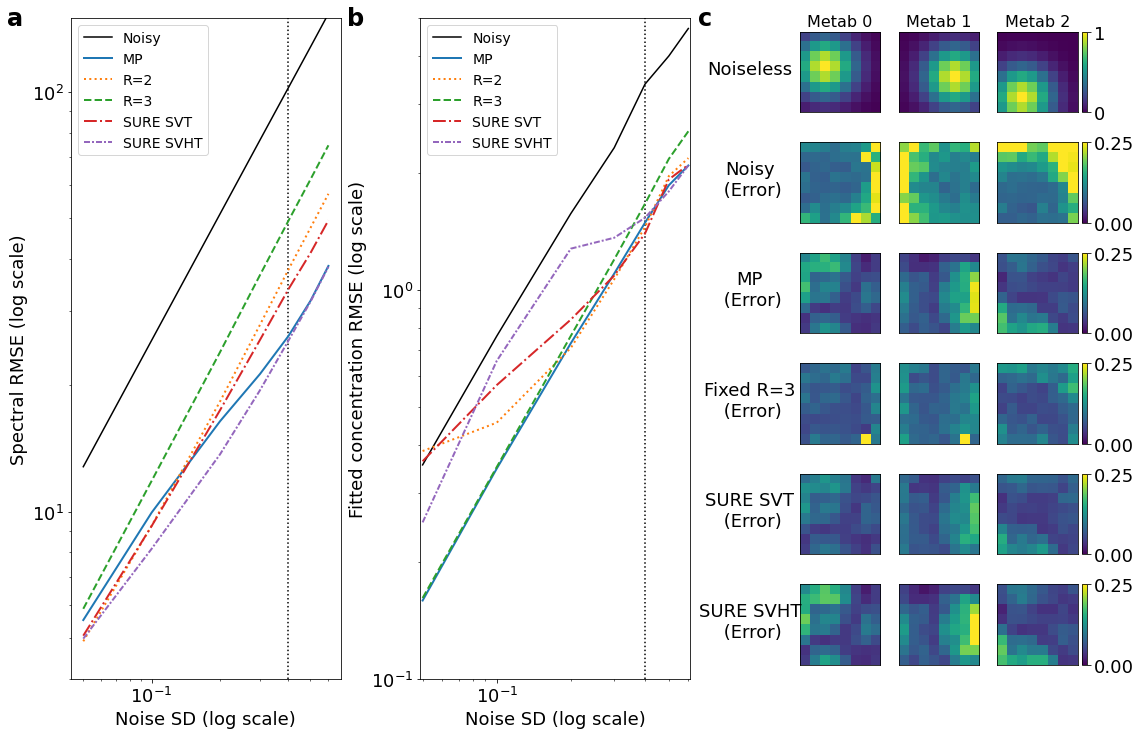

In [192]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

nslvl = 4
plt.rcParams.update({'font.size': 18})
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('axes', titlesize=16)    # legend fontsize

fig = plt.figure(figsize=(15,10), constrained_layout=True)
gs = fig.add_gridspec(6, 9)
ax1 = fig.add_subplot(gs[:, :3])

ax1.plot(noise_levels, np.nanmean(noisy_spec_rmse, axis=1), linestyle='-', color='k', label='Noisy')
ax1.plot(noise_levels, np.nanmean(mp_spec_rmse, axis=1), label='MP', linestyle='-', linewidth=2)
ax1.plot(noise_levels, np.nanmean(r2_spec_rmse, axis=1), label='R=2', linestyle=':', linewidth=2)
ax1.plot(noise_levels, np.nanmean(r3_spec_rmse, axis=1), label='R=3', linestyle='--', linewidth=2)
ax1.plot(noise_levels, np.nanmean(svt_spec_rmse, axis=1), label='SURE SVT', linestyle='-.', linewidth=2)
ax1.plot(noise_levels, np.nanmean(sure_spec_rmse, axis=1), label='SURE SVHT', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

ax1.vlines(noise_levels[nslvl],4,200,colors='k',linestyles=':')
ax1.legend(loc=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([4,150])
ax1.set_xlabel('Noise SD (log scale)')
ax1.set_ylabel('Spectral RMSE (log scale)')

ax2 = fig.add_subplot(gs[:, 3:6])

ax2.plot(noise_levels, np.nanmean(noisy_rmse_nan, axis=1), linestyle='-', color='k', label='Noisy')
ax2.plot(noise_levels, np.nanmean(mp_rmse_nan, axis=1), label='MP', linestyle='-', linewidth=2)
ax2.plot(noise_levels, np.nanmean(r2_rmse_nan, axis=1), label='R=2', linestyle=':', linewidth=2)
ax2.plot(noise_levels, np.nanmean(r3_rmse_nan, axis=1), label='R=3', linestyle='--', linewidth=2)
ax2.plot(noise_levels, np.nanmean(svt_rmse_nan, axis=1), label='SURE SVT', linestyle='-.', linewidth=2)
ax2.plot(noise_levels, np.nanmean(sure_rmse_nan, axis=1), label='SURE SVHT', linestyle=(0, (3, 1, 1, 1)), linewidth=2)

ax2.vlines(noise_levels[nslvl],0.1,10,colors='k',linestyles=':')
ax2.legend(loc=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlim([0.049,0.61])
ax2.set_ylim([0.1,5])
ax2.set_xlabel('Noise SD (log scale)')
ax2.set_ylabel('Fitted concentration RMSE (log scale)')

def rm_ticks(a):
    a.set_xticks([])
    a.set_yticks([])

for idx in range(3):
    ax = fig.add_subplot(gs[0, 6+idx])
    im = ax.matshow(weights[:,:,0,idx],vmin=0,vmax=1)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('Noiseless',rotation='horizontal',labelpad=50,y=0.425)
    ax.set_title(f'Metab {idx}')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 1])
    else:
        cax.set_visible(False)
    
    ax = fig.add_subplot(gs[1, 6+idx])
    im = ax.matshow(np.mean(np.abs(amps_noisy-weights),axis=1)[nslvl,:,:,0,idx],vmin=0,vmax=0.25)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('Noisy\n (Error)',rotation='horizontal',labelpad=50,y=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 0.25])
    else:
        cax.set_visible(False)
    
    ax = fig.add_subplot(gs[2, 6+idx])
    ax.matshow(np.mean(np.abs(amps_mp-weights),axis=1)[nslvl,:,:,0,idx],vmin=0,vmax=0.25)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('MP\n (Error)',rotation='horizontal',labelpad=50,y=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 0.25])
    else:
        cax.set_visible(False)

    ax = fig.add_subplot(gs[3, 6+idx])
    ax.matshow(np.mean(np.abs(amps_r3-weights),axis=1)[nslvl,:,:,0,idx],vmin=0,vmax=0.25)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('Fixed R=3\n (Error)',rotation='horizontal',labelpad=50,y=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 0.25])
    else:
        cax.set_visible(False)

    ax = fig.add_subplot(gs[4, 6+idx])
    ax.matshow(np.mean(np.abs(amps_svt-weights),axis=1)[nslvl,:,:,0,idx],vmin=0,vmax=0.25)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('SURE SVT\n (Error)',rotation='horizontal',labelpad=50,y=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 0.25])
    else:
        cax.set_visible(False)
        
    ax = fig.add_subplot(gs[5, 6+idx])
    ax.matshow(np.mean(np.abs(amps_sure-weights),axis=1)[nslvl,:,:,0,idx],vmin=0,vmax=0.25)
    rm_ticks(ax)
    if idx == 0:
        ax.set_ylabel('SURE SVHT\n (Error)',rotation='horizontal',labelpad=50,y=0.3)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    if idx == 2:        
        plt.colorbar(im, cax=cax, ticks=[0, 0.25])
    else:
        cax.set_visible(False)

fig.text(0.00, 0.98,'a',fontweight='bold',fontsize=24)
fig.text(0.315, 0.98,'b',fontweight='bold',fontsize=24)
fig.text(0.64, 0.98,'c',fontweight='bold',fontsize=24)
plt.savefig('figures/figure_2_mp_performance.png', bbox_inches='tight', dpi=300)


### Calculate summary stats

In [188]:
from scipy.stats import skew

skew_noisy, mean_noisy, std_noisy = [], [], []
skew_r3, mean_r3, std_r3 = [], [], []
skew_mp, mean_mp, std_mp = [], [], []
skew_sure, mean_sure, std_sure = [], [], []
for amn, amp, amr3, amsu in zip(amps_noisy,amps_mp,amps_r3, amps_svt):
    dist = (amn-weights).ravel().copy()
    dist = np.delete(dist,dist<-1)
    dist = np.delete(dist,dist>1)
    skew_noisy.append(skew(dist))
    mean_noisy.append(np.abs(np.mean(dist)))
    std_noisy.append(np.std(dist))

    dist = (amp-weights).ravel().copy()
    dist = np.delete(dist,dist<-1)
    dist = np.delete(dist,dist>1)
    skew_mp.append(skew(dist))
    mean_mp.append(np.abs(np.mean(dist)))
    std_mp.append(np.std(dist))
    
    dist = (amr3-weights).ravel().copy()
    dist = np.delete(dist,dist<-1)
    dist = np.delete(dist,dist>1)
    skew_r3.append(skew(dist))
    mean_r3.append(np.abs(np.mean(dist)))
    std_r3.append(np.std(dist))

    dist = (amsu-weights).ravel().copy()
    dist = np.delete(dist,dist<-1)
    dist = np.delete(dist,dist>1)
    skew_sure.append(skew(dist))
    mean_sure.append(np.abs(np.mean(dist)))
    std_sure.append(np.std(dist))

### Plot histograms of voxel-wise error and summary stats

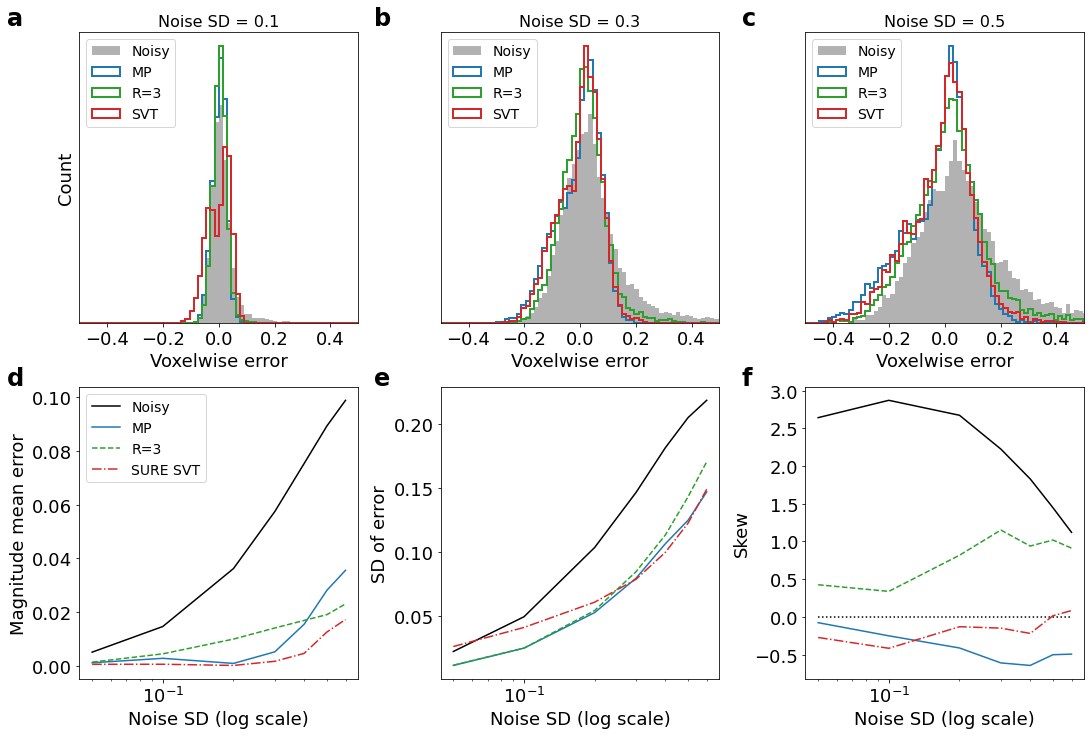

In [193]:
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(5)]
colors = [(0,0,0,1),] + colors
    
fig = plt.figure(figsize=(15,10), constrained_layout=True)
gs = fig.add_gridspec(2,3)
hist_axes = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])]
bins = 100
to_plot = [1, 3, 5]
for indicies, ax in zip(to_plot, hist_axes):
    ax.hist((amps_noisy-weights)[indicies,:,:,:,:,:].ravel(),range=(-0.75, 0.75),bins=bins,color='k',alpha=0.3,label='Noisy')
    ax.hist((amps_mp-weights)[indicies,:,:,:,:,:].ravel(),range=(-0.75, 0.75),bins=bins, color=colors[1],histtype='step',alpha=1,label='MP',linewidth=2)
    ax.hist((amps_r3-weights)[indicies,:,:,:,:,:].ravel(),range=(-0.75, 0.75),bins=bins, color=colors[3],histtype='step',alpha=1,label='R=3',linewidth=2)
    ax.hist((amps_svt-weights)[indicies,:,:,:,:,:].ravel(),range=(-0.75, 0.75),bins=bins, color=colors[4],histtype='step',alpha=1,label='SVT',linewidth=2)
    ax.set_title(f'Noise SD = {noise_levels[indicies]}')
    ax.set_xlabel(f'Voxelwise error')
    ax.set_xlim([-0.5,0.5])
    if indicies == 1:
        ax.set_ylabel('Count')
    ax.set_yticks([])
    ax.legend(loc=2)
    
ax_mean = fig.add_subplot(gs[1,0])
ax_mean.semilogx(noise_levels, mean_noisy,label='Noisy', color=colors[0])
ax_mean.semilogx(noise_levels, mean_mp,label='MP', color=colors[1])
ax_mean.semilogx(noise_levels, mean_r3,label='R=3', linestyle='--', color=colors[3])
ax_mean.semilogx(noise_levels, mean_sure,label='SURE SVT', linestyle='-.', color=colors[4])
ax_mean.set_xlabel('Noise SD (log scale)')
ax_mean.set_ylabel('Magnitude mean error')
ax_mean.legend()

ax_std = fig.add_subplot(gs[1,1])
ax_std.semilogx(noise_levels, std_noisy,label='Noisy', color=colors[0])
ax_std.semilogx(noise_levels, std_mp,label='MP', color=colors[1])
ax_std.semilogx(noise_levels, std_r3,label='R=3', linestyle='--', color=colors[3])
ax_std.semilogx(noise_levels, std_sure,label='SURE SVT', linestyle='-.', color=colors[4])
ax_std.set_xlabel('Noise SD (log scale)')
ax_std.set_ylabel('SD of error')

ax_skew = fig.add_subplot(gs[1,2])
ax_skew.semilogx(noise_levels, skew_noisy,label='Noisy', color=colors[0])
ax_skew.semilogx(noise_levels, skew_mp,label='MP', color=colors[1])
ax_skew.semilogx(noise_levels, skew_r3,label='R=3', linestyle='--', color=colors[3])
ax_skew.semilogx(noise_levels, skew_sure,label='SURE SVT', linestyle='-.', color=colors[4])
ax_skew.hlines(0,noise_levels[0],noise_levels[-1],linestyles=':',color='k')
ax_skew.set_xlabel('Noise SD (log scale)')
ax_skew.set_ylabel('Skew')

fig.text(0.00, 0.98,'a',fontweight='bold',fontsize=24)
fig.text(0.34, 0.98,'b',fontweight='bold',fontsize=24)
fig.text(0.68, 0.98,'c',fontweight='bold',fontsize=24)
fig.text(0.00, 0.48,'d',fontweight='bold',fontsize=24)
fig.text(0.34, 0.48,'e',fontweight='bold',fontsize=24)
fig.text(0.68, 0.48,'f',fontweight='bold',fontsize=24)
plt.savefig('figures/figure_3_bias_hist.png', bbox_inches='tight', dpi=300)